In [0]:
###############################################################################
# SETUP - EXECUTE THIS FIRST                                                  #
###############################################################################
# 1. Go into "Runtime" -> "Change runtime type" and Select "GPU" for hardward accelerator
# 2. Click the "Connect" button, at the right to start the instance.
# This will get the dataset into this instance
# Note: You can change the fruits_200.zip to fruits_300.zip or fruits_400.zip
# Note2: To change the picture, go into Runtime -> Reset All runtime first to clear drive
!wget https://github.com/nknewlands/DeepLearningShortCourse/raw/master/Day1/Pineapple_and_Orange/fruits_200.zip
!unzip fruits_200.zip

--2019-08-13 19:37:58--  https://github.com/nknewlands/DeepLearningShortCourse/raw/master/Day1/Pineapple_and_Orange/fruits_200.zip
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nknewlands/DeepLearningShortCourse/master/Day1/Pineapple_and_Orange/fruits_200.zip [following]
--2019-08-13 19:37:58--  https://raw.githubusercontent.com/nknewlands/DeepLearningShortCourse/master/Day1/Pineapple_and_Orange/fruits_200.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12119380 (12M) [application/zip]
Saving to: ‘fruits_200.zip’

fruits_200.zip      100%[===================>]  11.56M  --.-KB/s    in 0.09s 

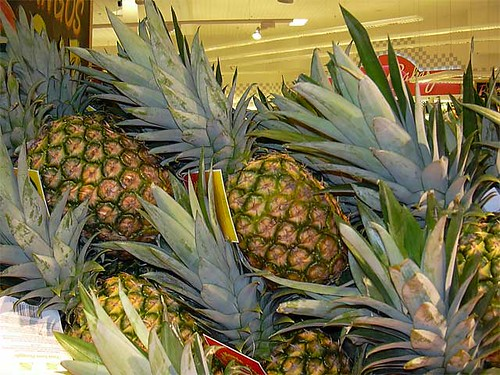

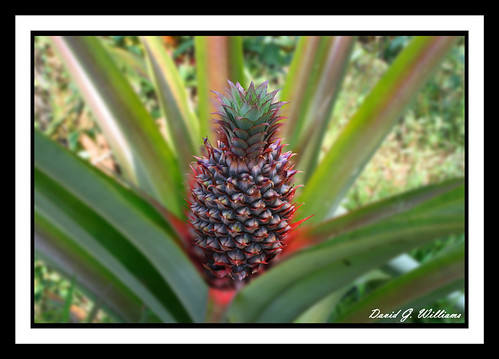

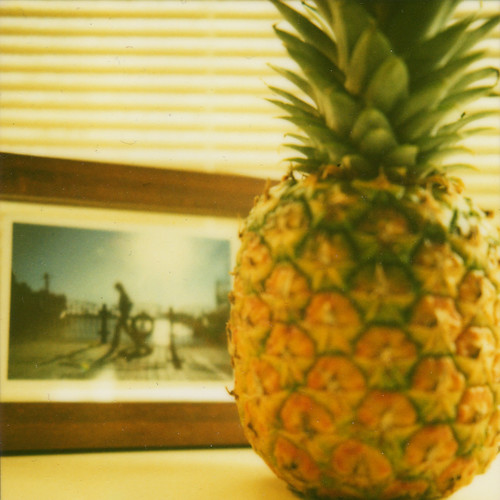

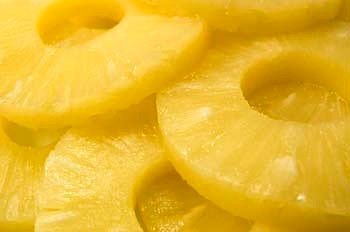

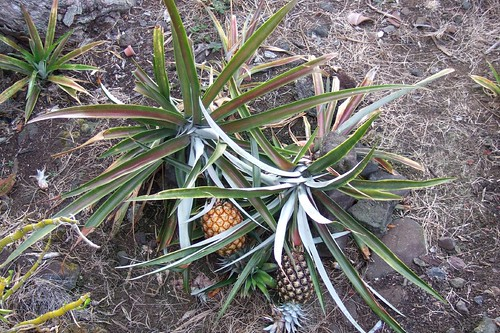

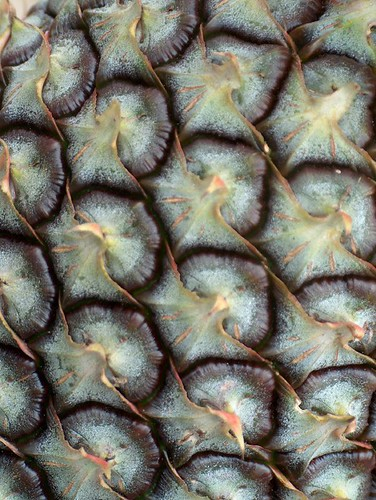

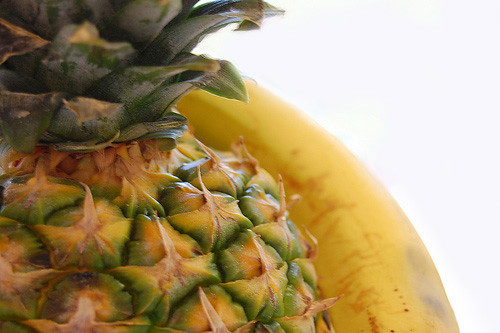

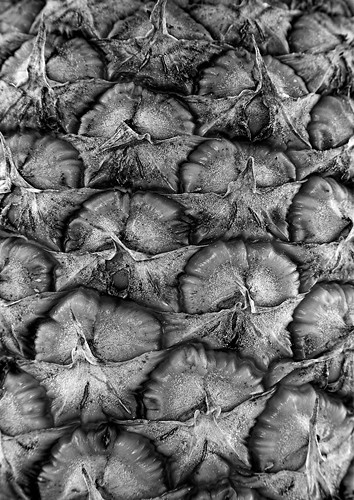

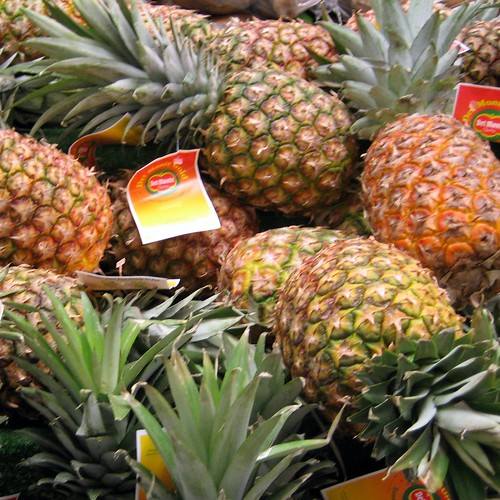

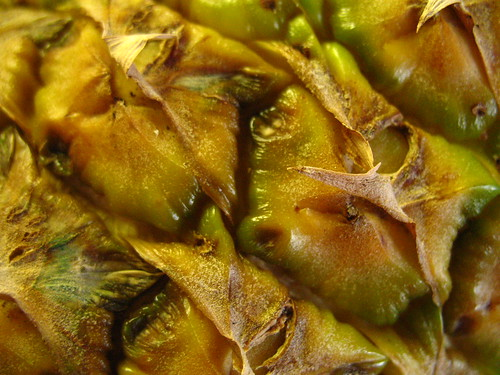

In [0]:
# SHOW SOME PICTURE
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, HTML, display
%matplotlib inline

for img_path in glob.glob('fruits_training/pineapple/*.jpg')[22:32]:
    display(Image(img_path))

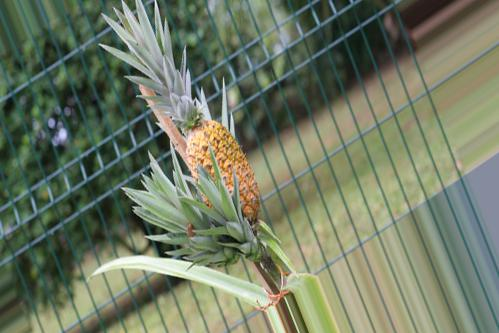

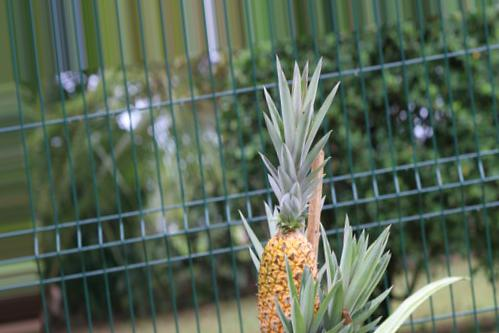

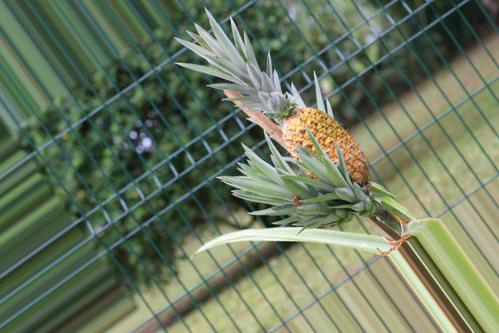

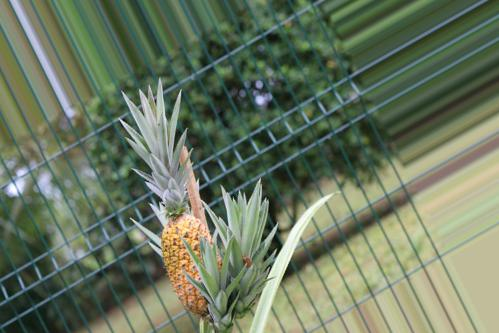

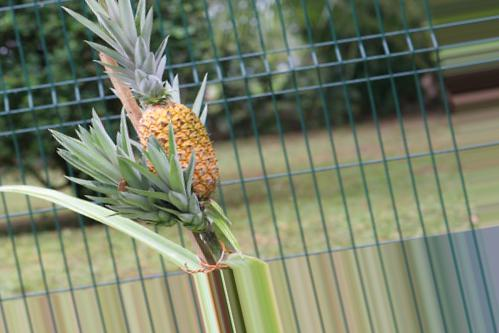

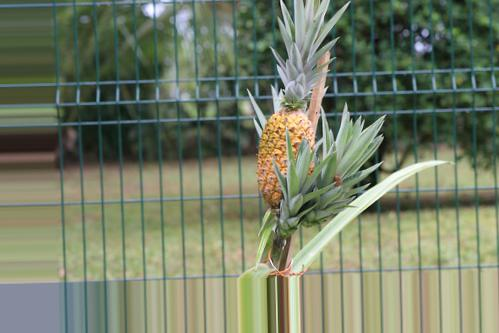

In [0]:
################################################################################ 
# SHOW THE EFFECT OF DATA AUGMENTATION (TUTORIAL ONLY)                         #
################################################################################ 
!rm -rf preview
!mkdir preview
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('fruits_training/pineapple/143989182_64c8eb01aa.jpg')  # Image de base
x = img_to_array(img)  # Transformation de l'image en un tableau numérique
x = x.reshape((1,) + x.shape) 

# La commande .flow() permet de générer autant 
# d'image que l'on veut...
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='pineapple', save_format='jpg'):
    i += 1
    if i > 5:
        break  # On arrête après 5 images.

for img_path in glob.glob('preview/pineapple*.jpg'):
    display(Image(img_path))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_13 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_14 (Activation)   (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)        36928     
__________

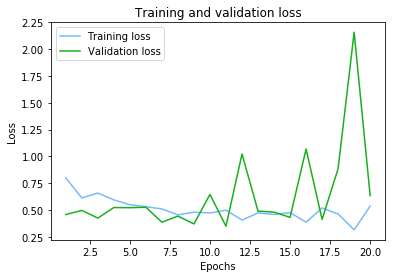

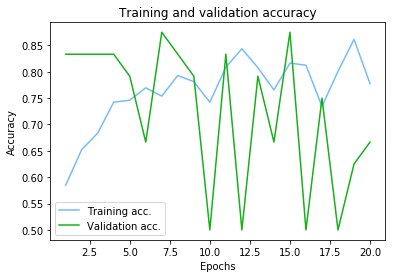

30
Total samples: 30 Final accuracy: 0.5833333134651184
2/1 [================================================] - 0s 134ms/step


<Figure size 432x288 with 0 Axes>

In [0]:
#!/usr/bin/python
#
# Fruits part 1. Code in python
# Inpired by the code from Francois Chollet. 
#                     "Deep learning with Python." Manning (2018) 362 pages.
# 
# From François Chollet's book:
# "Convnets are the best type of machine-learning models for computer-vision tasks. 
#  It’s possible to train one from scratch even on a very small dataset, with decent results.
#  On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way,
#  to fight overfitting when you’re working with image data.
#  It’s easy to reuse an existing convnet on a new dataset via feature extraction. 
#  This is a valuable technique for working with small image datasets."
#
# Preparation: Unzip the file fruits_200.zip containing oranges and pinapples pictures 
#              in the same directory as this file. Note, this is a VERY VERY small dataset
#              created using picture from the ImageNet dataset and used for demonstration.
# 
#              Orange: http://image-net.org/synset?wnid=n07747607
#              Pineapple: http://image-net.org/synset?wnid=n07753275
#
#               fruits_200.zip
#               ---------------
#               Training  : 140 (70%)
#               Validation: 30 (15%)
#               Test      : 30 (15%)
#               Training:   orange (72), pineapple (68)
#               Validation: orange (19), pineapple (11)
#               Test :      orange (15), pineapple (15)
#
#               fruits_300.zip
#               ---------------
#               Training  : 210 (70%)
#               Validation: 45  (15%)
#               Test      : 45
#
#               fruits_400.zip
#               ---------------
#               Training  : 280 (70%)
#               Validation: 60  (15%)
#               Test      : 60
###############################################################################
# GLOBAL IMPORT                                                               #
###############################################################################
from __future__ import absolute_import, unicode_literals, division, print_function
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop
from keras.callbacks import *
from keras import backend as K

###############################################################################
# HELPER FUNCTIONS                                                            #
###############################################################################
def number_of_files(dirname):
    cpt = sum([len(files) for r, d, files in os.walk(dirname)])
    return cpt

################################################################################ 
# DEFINITION OF INPUT DATA                                                     #
################################################################################
train_data_dir = 'fruits_training'
validation_data_dir = 'fruits_validation'
test_data_dir='fruits_test'
epochs = 20    # Number of iteration over the dataset
batch_size = 24 # Number of images processed at the same time 
nb_train_samples=number_of_files(train_data_dir)*2
nb_validation_samples=number_of_files(validation_data_dir)
nb_test_samples=number_of_files(test_data_dir)
img_width, img_height = 150, 150 # Training dimensions i.e. image sizes will be reduced 

# This depend on the back-end (mxnet, Tensorflow,...)
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

    
################################################################################ 
# CNN                                                                          #
################################################################################
model = Sequential() # Type of model  
# see https://keras.io/getting-started/sequential-model-guide/
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Last layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5)) # Dropout
model.add(Dense(1)) # One last cell
model.add(Activation('sigmoid'))

################################################################################ 
# OPTIMIZATION                                                                 #
################################################################################

rmsprop=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

model.summary() # Display a summary of the model

################################################################################ 
# DATA AUGMENTATION                                                            #
################################################################################

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Only normalize on validation set
val_datagen = ImageDataGenerator(
    rescale=1. / 255,
) 


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = val_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
	shuffle=False,
    class_mode='binary')

################################################################################ 
# RUN MODEL                                                                    #
################################################################################
csv_logger = CSVLogger('model_log.csv', append=True, separator=';')
checkpointer = ModelCheckpoint(filepath='model.{epoch:02d}-{val_acc:.2f}.hdf5',verbose=1, monitor='val_loss', save_best_only=True)

original_hist=model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[csv_logger,checkpointer],
    verbose=1
)

################################################################################ 
# SAVE MODEL                                                                   #
################################################################################
model.save("final_model.hdf5")
#
# Note: To load model:
# from keras.models import load_model 
# model=load_model("final_model.hdf5")
################################################################################ 
# VISUALIZE THE TRAINING RESULTS                                               #
################################################################################

import matplotlib.pyplot as plt
%matplotlib inline
original_hist.history

acc = original_hist.history['acc']
val_acc = original_hist.history['val_acc']
loss = original_hist.history['loss']
val_loss = original_hist.history['val_loss']
epochs = range(1, len(acc) + 1)

# Colors are from are color from https://xkcd.com/color/rgb/
plt.plot(epochs, loss, 'xkcd:sky blue', label='Training loss')
plt.plot(epochs, val_loss, 'xkcd:green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss.png', bbox_inches='tight')

plt.clf()   # New figure
acc_values = original_hist.history['acc']
val_acc_values = original_hist.history['val_acc']

plt.plot(epochs, acc, 'xkcd:sky blue', label='Training acc.')
plt.plot(epochs, val_acc, 'xkcd:green', label='Validation acc.')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('accuracy.png', bbox_inches='tight')

################################################################################
# RUN THE MODEL ON THE TEST DATA                                               #
################################################################################

filenames = test_generator.filenames
nb_samples = len(filenames)
y_true_labels = test_generator.classes
y_indices=test_generator.class_indices
print(len(y_true_labels))

# Evaluate all the test sample
evalu = model.evaluate_generator(test_generator,steps = nb_samples // batch_size)

print("Total samples: "+str(nb_test_samples)+" Final accuracy: "+str(evalu[1]))
test_generator.reset()
predicted = model.predict_generator(test_generator,steps = nb_samples / batch_size, verbose=1)
y_pred = np.rint(np.concatenate(predicted, axis=0)).astype(int) # round to nearest integer

# Write some predictions
labels = ['orange','pineapple']
predictions = [labels[k] for k in y_pred]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Values":np.concatenate(predicted, axis=0),
                      "Predictions":predictions})
results.to_csv("predicted.csv", sep=";")

################################################################################
# TO DO                                                                        #
################################################################################
#
# 1. Try to adjust the batch size and the number of epoch
# 2. Add mode layers to the CNN
# 3. Try to increase the number of samples (see fruits_300.zip and fruits_400.zip)
# 4. Part 2. Use pre-trained neural networks
